# Predict regulatory regions from the DNA sequence

In this notebook we illustrate several variants how to predict regulatory regions (of a toy example) from the DNA sequence.
The reference genome is made up of a concatenation of Oct4 and Mafk binding sites and we shall use all regions on chromosome 'pseudo1' as training
and 'pseudo2' as test chromosomes.

In [1]:
import os

import numpy as np
from keras import Model
from keras import backend as K
from keras.layers import Conv2D

from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import Reshape

from pkg_resources import resource_filename

from janggu import Janggu
from janggu import Scorer
from janggu import inputlayer
from janggu import outputdense
from janggu.data import Bioseq
from janggu.data import Cover
from janggu.data import ReduceDim
from janggu.layers import DnaConv2D
from janggu.layers import LocalAveragePooling2D
from janggu.utils import ExportClustermap
from janggu.utils import ExportTsne
from janggu.utils import ExportTsv

from IPython.display import Image

np.random.seed(1234)

Using TensorFlow backend.


First, we need to specify the output directory in which the results are stored.

In [2]:
os.environ['JANGGU_OUTPUT'] = '/home/wkopp/janggu_examples'

Specify the DNA sequence feature order. Order 1, 2 and 3 correspond to mono-, di- and tri-nucleotide based features (see Tutorial).

In [3]:
order = 3

In [4]:
# load the dataset
# The pseudo genome represents just a concatenation of all sequences
# in sample.fa and sample2.fa. Therefore, the results should be almost
# identically to the models obtained from classify_fasta.py.
REFGENOME = resource_filename('janggu', 'resources/pseudo_genome.fa')
# ROI contains regions spanning positive and negative examples
ROI_TRAIN_FILE = resource_filename('janggu', 'resources/roi_train.bed')
ROI_TEST_FILE = resource_filename('janggu', 'resources/roi_test.bed')
# PEAK_FILE only contains positive examples
PEAK_FILE = resource_filename('janggu', 'resources/scores.bed')

Load the datasets for training and testing

In [5]:
# Training input and labels are purely defined genomic coordinates
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   binsize=200,
                                   order=order,
                                   cache=True)

LABELS = Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200,
                               cache=True,
                               storage='sparse')


DNA_TEST = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                        roi=ROI_TEST_FILE,
                                        binsize=200,
                                        order=order)

LABELS_TEST = Cover.create_from_bed('peaks',
                                    bedfiles=PEAK_FILE,
                                    roi=ROI_TEST_FILE,
                                    binsize=200,
                                    resolution=200,
                                    storage='sparse')


loading from lazy loader
reload /home/wkopp/janggu_examples/datasets/dna/08ee6c24faf5ebe600a7fc361e30a94ef2db75b41ffa057dabf5d5d7ef800e49.npz
loading from bed lazy loader
reload /home/wkopp/janggu_examples/datasets/peaks/db9ac6eef98519c37a8604886d1029a71d95374d8b9a6c10f283df557dd1cded.npz
loading from lazy loader
loading from bed lazy loader


## 1) Example with an ordinary keras model

Specify a keras model with compatible dimesions for the example.

In [6]:
xin = Input((200 - order + 1, 1, pow(4, order)))
layer = DnaConv2D(Conv2D(30, (21, 1),
                         activation='relu'))(xin)
layer = GlobalAveragePooling2D()(layer)
layer = Dense(1, activation='sigmoid')(layer)

# the last one is used to make the dimensionality compatible with
# the coverage dataset dimensions.
# Alternatively, the ReduceDim dataset wrapper may be used to transform
# the output to a 2D dataset object.
output = Reshape((1, 1, 1))(layer)

model = Model(xin, output)

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])
model.summary()



Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 198, 1, 64)        0         
_________________________________________________________________
dna_conv2d_1 (DnaConv2D)     (None, 178, 1, 30)        40350     
_________________________________________________________________
global_average_pooling2d_1 ( (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 1)           0         
Total params: 40,381
Trainable params: 40,381
Non-trainable params: 0
_________________________________________________________________


In [7]:
hist = model.fit(DNA, LABELS, epochs=100,
                 validation_data=(DNA_TEST, LABELS_TEST))

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)



Instructions for updating:
Use tf.cast instead.
Train on 7797 samples, validate on 200 samples
Epoch 1/100
7797/7797 [==============================] - 9s 1ms/step - loss: 0.5611 - acc: 0.7354 - val_loss: 0.4951 - val_acc: 0.7750
Epoch 2/100
7797/7797 [==============================] - 10s 1ms/step - loss: 0.4607 - acc: 0.7980 - val_loss: 0.4314 - val_acc: 0.8150
Epoch 3/100
7797/7797 [==============================] - 10s 1ms/step - loss: 0.4114 - acc: 0.8222 - val_loss: 0.4038 - val_acc: 0.7950
Epoch 4/100
7797/7797 [==============================] - 10s 1ms/step - loss: 0.3785 - acc: 0.8425 - val_loss: 0.3758 - val_acc: 0.8350
Epoch 5/100
7797/7797 [==============================] - 9s 1ms/step - loss: 0.3513 - acc: 0.8551 - val_loss: 0.3559 - val_acc: 0.8550
Epoch 6/100
7797/7797 [==============================] - 10s 1ms/step - loss: 0.3255 - acc: 0.8657 - val_loss: 0.3316 - val_acc: 0.8500
Epoch 7/100
7797/7797 [==============================] - 9s 1ms/step - loss: 0.3036 - acc: 

7797/7797 [==============================] - 18s 2ms/step - loss: 0.0353 - acc: 0.9931 - val_loss: 0.1122 - val_acc: 0.9500
Epoch 59/100
7797/7797 [==============================] - 18s 2ms/step - loss: 0.0343 - acc: 0.9937 - val_loss: 0.1078 - val_acc: 0.9550
Epoch 60/100
7797/7797 [==============================] - 19s 2ms/step - loss: 0.0333 - acc: 0.9938 - val_loss: 0.1005 - val_acc: 0.9650
Epoch 61/100
7797/7797 [==============================] - 18s 2ms/step - loss: 0.0323 - acc: 0.9944 - val_loss: 0.1215 - val_acc: 0.9400
Epoch 62/100
7797/7797 [==============================] - 17s 2ms/step - loss: 0.0315 - acc: 0.9946 - val_loss: 0.1055 - val_acc: 0.9600
Epoch 63/100
7797/7797 [==============================] - 17s 2ms/step - loss: 0.0306 - acc: 0.9942 - val_loss: 0.0984 - val_acc: 0.9550
Epoch 64/100
7797/7797 [==============================] - 17s 2ms/step - loss: 0.0297 - acc: 0.9955 - val_loss: 0.1013 - val_acc: 0.9550
Epoch 65/100
7797/7797 [==============================

the predictions may be converted back to Cover object and subsequently exported as bigwig in order to inspect the plausibility of the results.

In [8]:

# convert the prediction to a cover object
pred = model.predict(DNA_TEST)
cov_pred = Cover.create_from_array('BindingProba', pred, LABELS_TEST.gindexer)

# predictions (or feature activities) can finally be exported to bigwig
cov_pred.export_to_bigwig(output_dir=os.environ['JANGGU_OUTPUT'])


## 2) Example with Janggu model wrapper

Now, we shall use the Janggu model, which just wraps a keras model, for fitting and evaluation.

First we define model using keras using a method. The decorators will automatically instantiate the initial layers and the output layers with the correct dimensionality. In the example above, this needed to be specified explicitly.

In [9]:
@inputlayer
@outputdense('sigmoid')
def double_stranded_model_dnaconv(inputs, inp, oup, params):
    """ keras model for scanning both DNA strands.

    A more elegant way of scanning both strands for motif occurrences
    is achieved by the DnaConv2D layer wrapper, which internally
    performs the convolution operation with the normal kernel weights
    and the reverse complemented weights.
    """
    with inputs.use('dna') as layer:
        # the name in inputs.use() should be the same as the dataset name.
        layer = DnaConv2D(Conv2D(params[0], (params[1], 1),
                                 activation=params[2]))(layer)
    output = GlobalAveragePooling2D(name='motif')(layer)
    return inputs, output


Now the model can be instantiated accordingly. We will also use a specific model name (which is optional).

In [10]:
modelname = 'dna2peak_ex1_order{}'.format(order)

In [11]:
# create a new model object
model = Janggu.create(template=double_stranded_model_dnaconv,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=ReduceDim(LABELS),
                      name=modelname)

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])



Model fitting is similar as before.

Note also the use of ReduceDim which converts the original 4D Cover object to 2D table-like data structure. This is just for convenience, since it is also possible to set up a model as in the previous example.

In [13]:
hist = model.fit(DNA, ReduceDim(LABELS), epochs=100)

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)


Epoch 1/100
244/244 [==============================] - 18s 75ms/step - loss: 0.6332 - acc: 0.6424
Epoch 2/100
244/244 [==============================] - 19s 79ms/step - loss: 0.5250 - acc: 0.7666
Epoch 3/100
244/244 [==============================] - 19s 79ms/step - loss: 0.4657 - acc: 0.7964
Epoch 4/100
244/244 [==============================] - 19s 78ms/step - loss: 0.4252 - acc: 0.8181
Epoch 5/100
244/244 [==============================] - 19s 78ms/step - loss: 0.3955 - acc: 0.8320
Epoch 6/100
244/244 [==============================] - 19s 78ms/step - loss: 0.3709 - acc: 0.8461
Epoch 7/100
244/244 [==============================] - 19s 77ms/step - loss: 0.3477 - acc: 0.8542
Epoch 8/100
244/244 [==============================] - 19s 77ms/step - loss: 0.3253 - acc: 0.8690
Epoch 9/100
244/244 [==============================] - 15s 62ms/step - loss: 0.3035 - acc: 0.8795
Epoch 10/100
244/244 [==============================] - 11s 44ms/step - loss: 0.2828 - acc: 0.8882
Epoch 11/100
244/24

244/244 [==============================] - 9s 35ms/step - loss: 0.0182 - acc: 0.9982
Epoch 85/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0181 - acc: 0.9986
Epoch 86/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0175 - acc: 0.9986
Epoch 87/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0172 - acc: 0.9988
Epoch 88/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0166 - acc: 0.9987
Epoch 89/100
244/244 [==============================] - 9s 35ms/step - loss: 0.0161 - acc: 0.9988
Epoch 90/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0160 - acc: 0.9988
Epoch 91/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0155 - acc: 0.9987
Epoch 92/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0152 - acc: 0.9992
Epoch 93/100
244/244 [==============================] - 9s 36ms/step - loss: 0.0146 - acc: 0.9991
Epoch 94/100
244/244 [===========

[0.10057897180318832, 0.97]

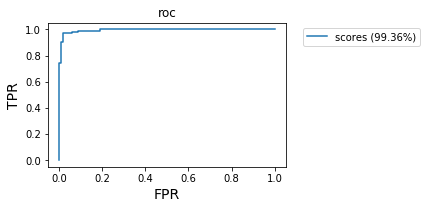

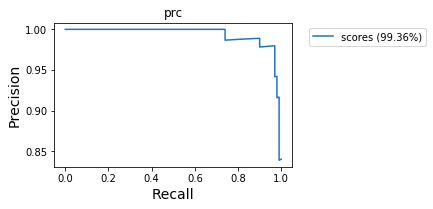

In [14]:
# do the evaluation on the independent test data
model.evaluate(DNA_TEST, ReduceDim(LABELS_TEST), datatags=['test'],
               callbacks=['auc', 'auprc', 'roc', 'prc'])

In [15]:
evaluation_folder = os.path.join(os.environ['JANGGU_OUTPUT'], 'evaluation', modelname, 'test')

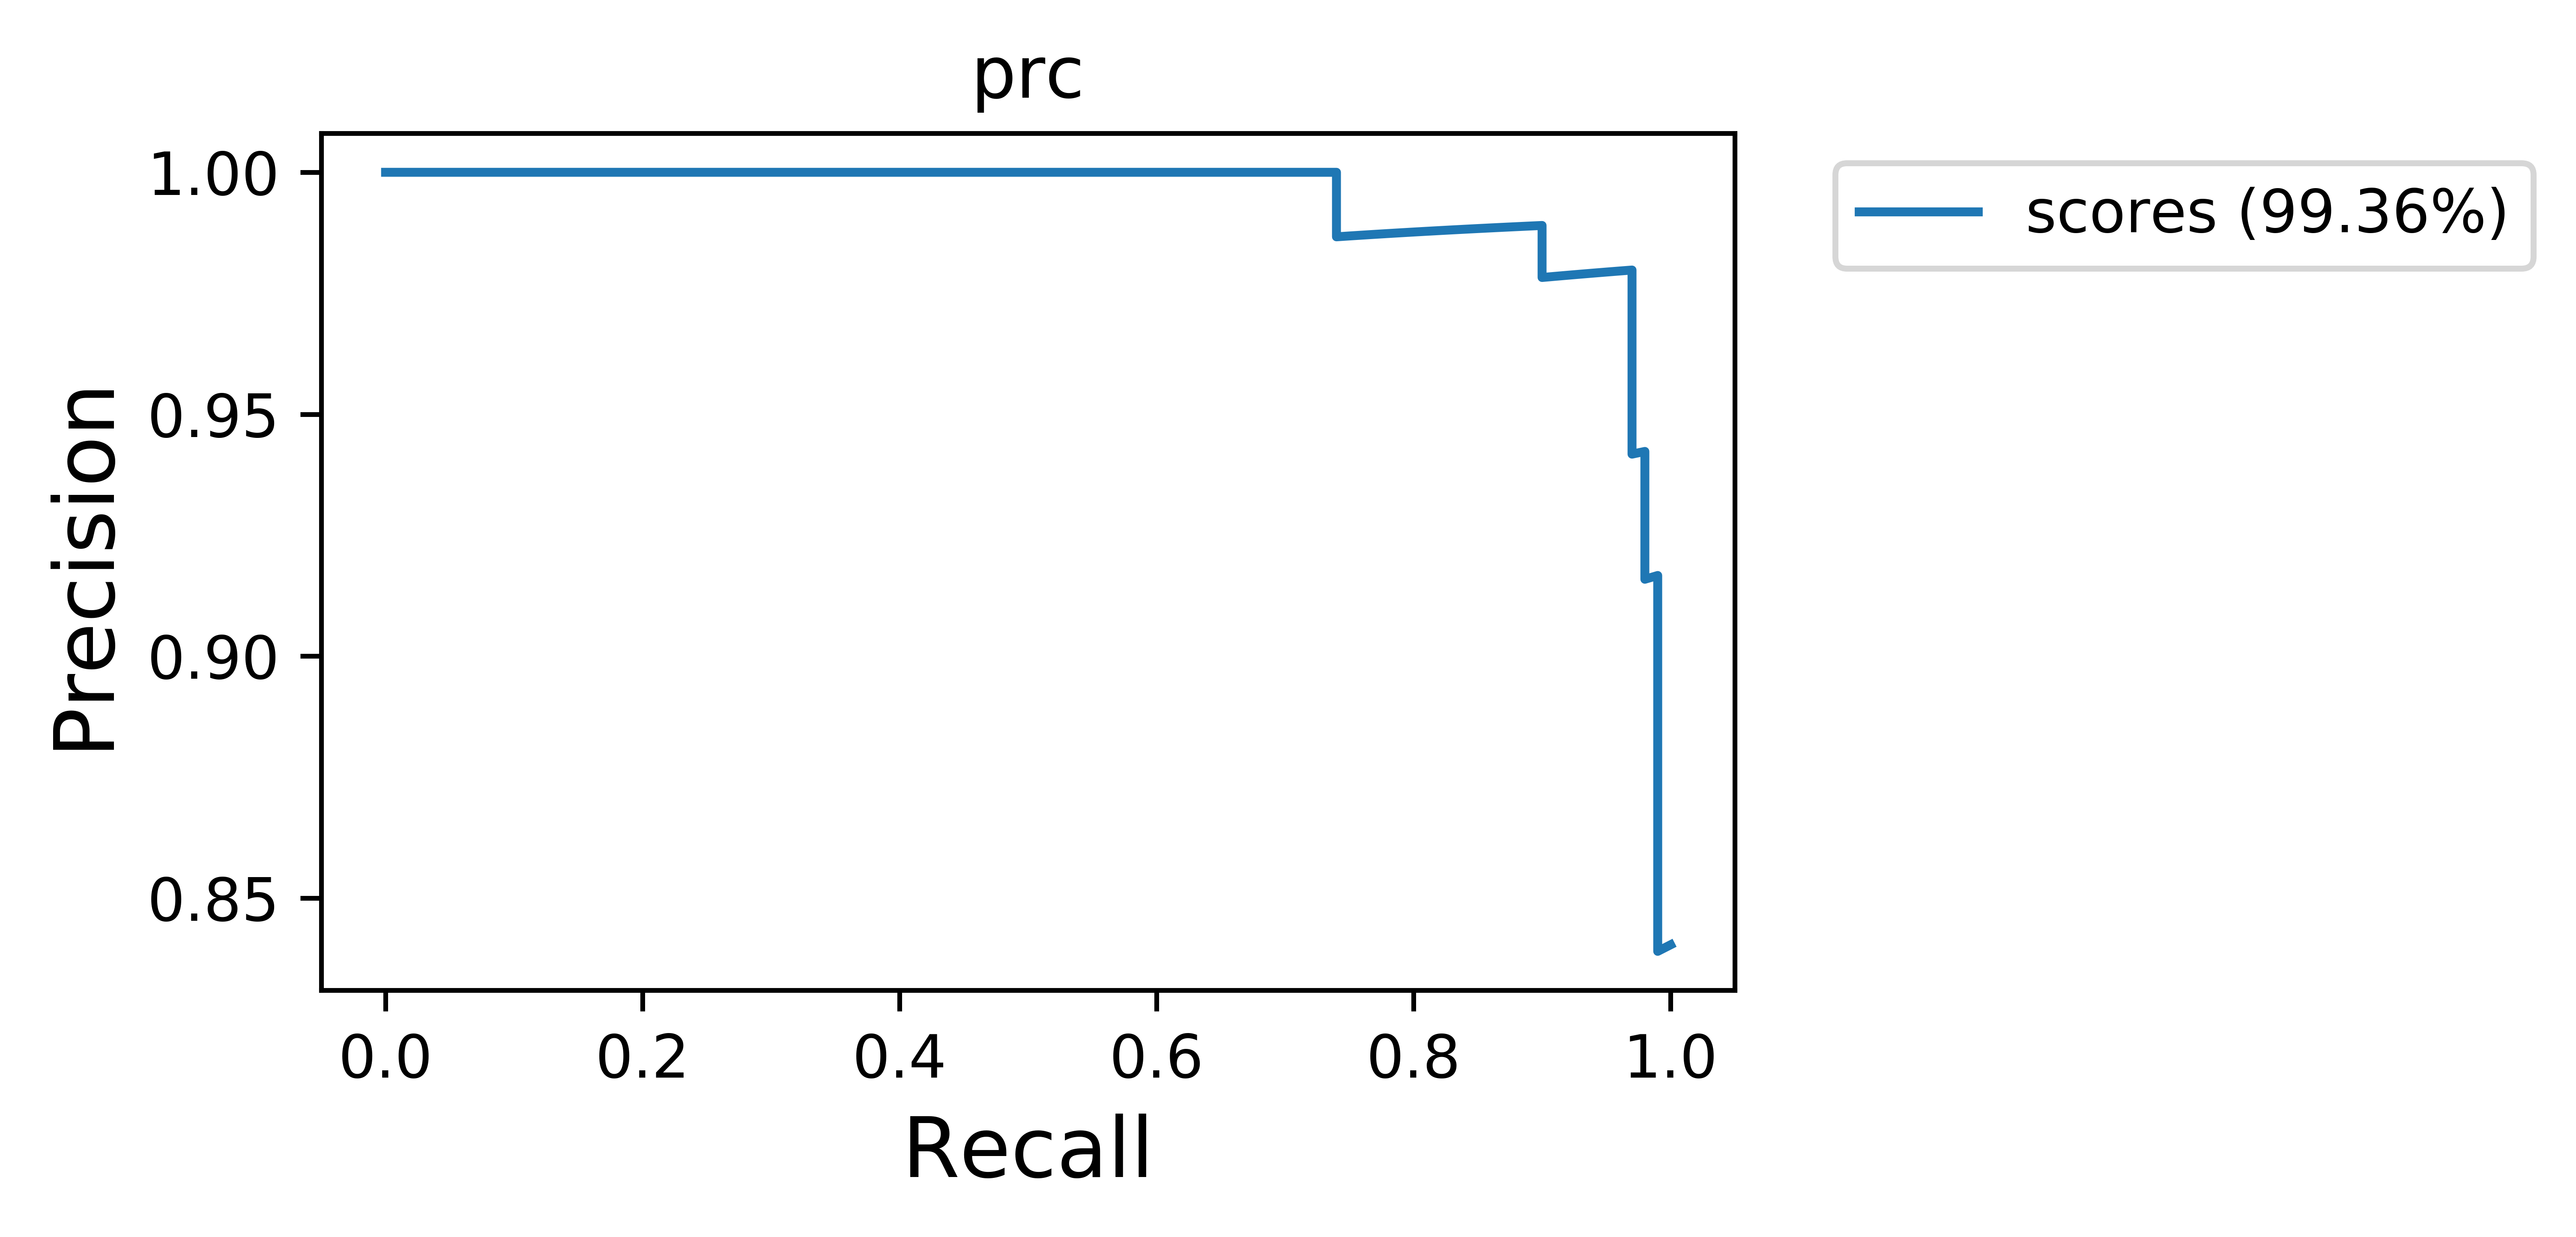

In [16]:
Image(os.path.join(evaluation_folder, 'prc.png'))

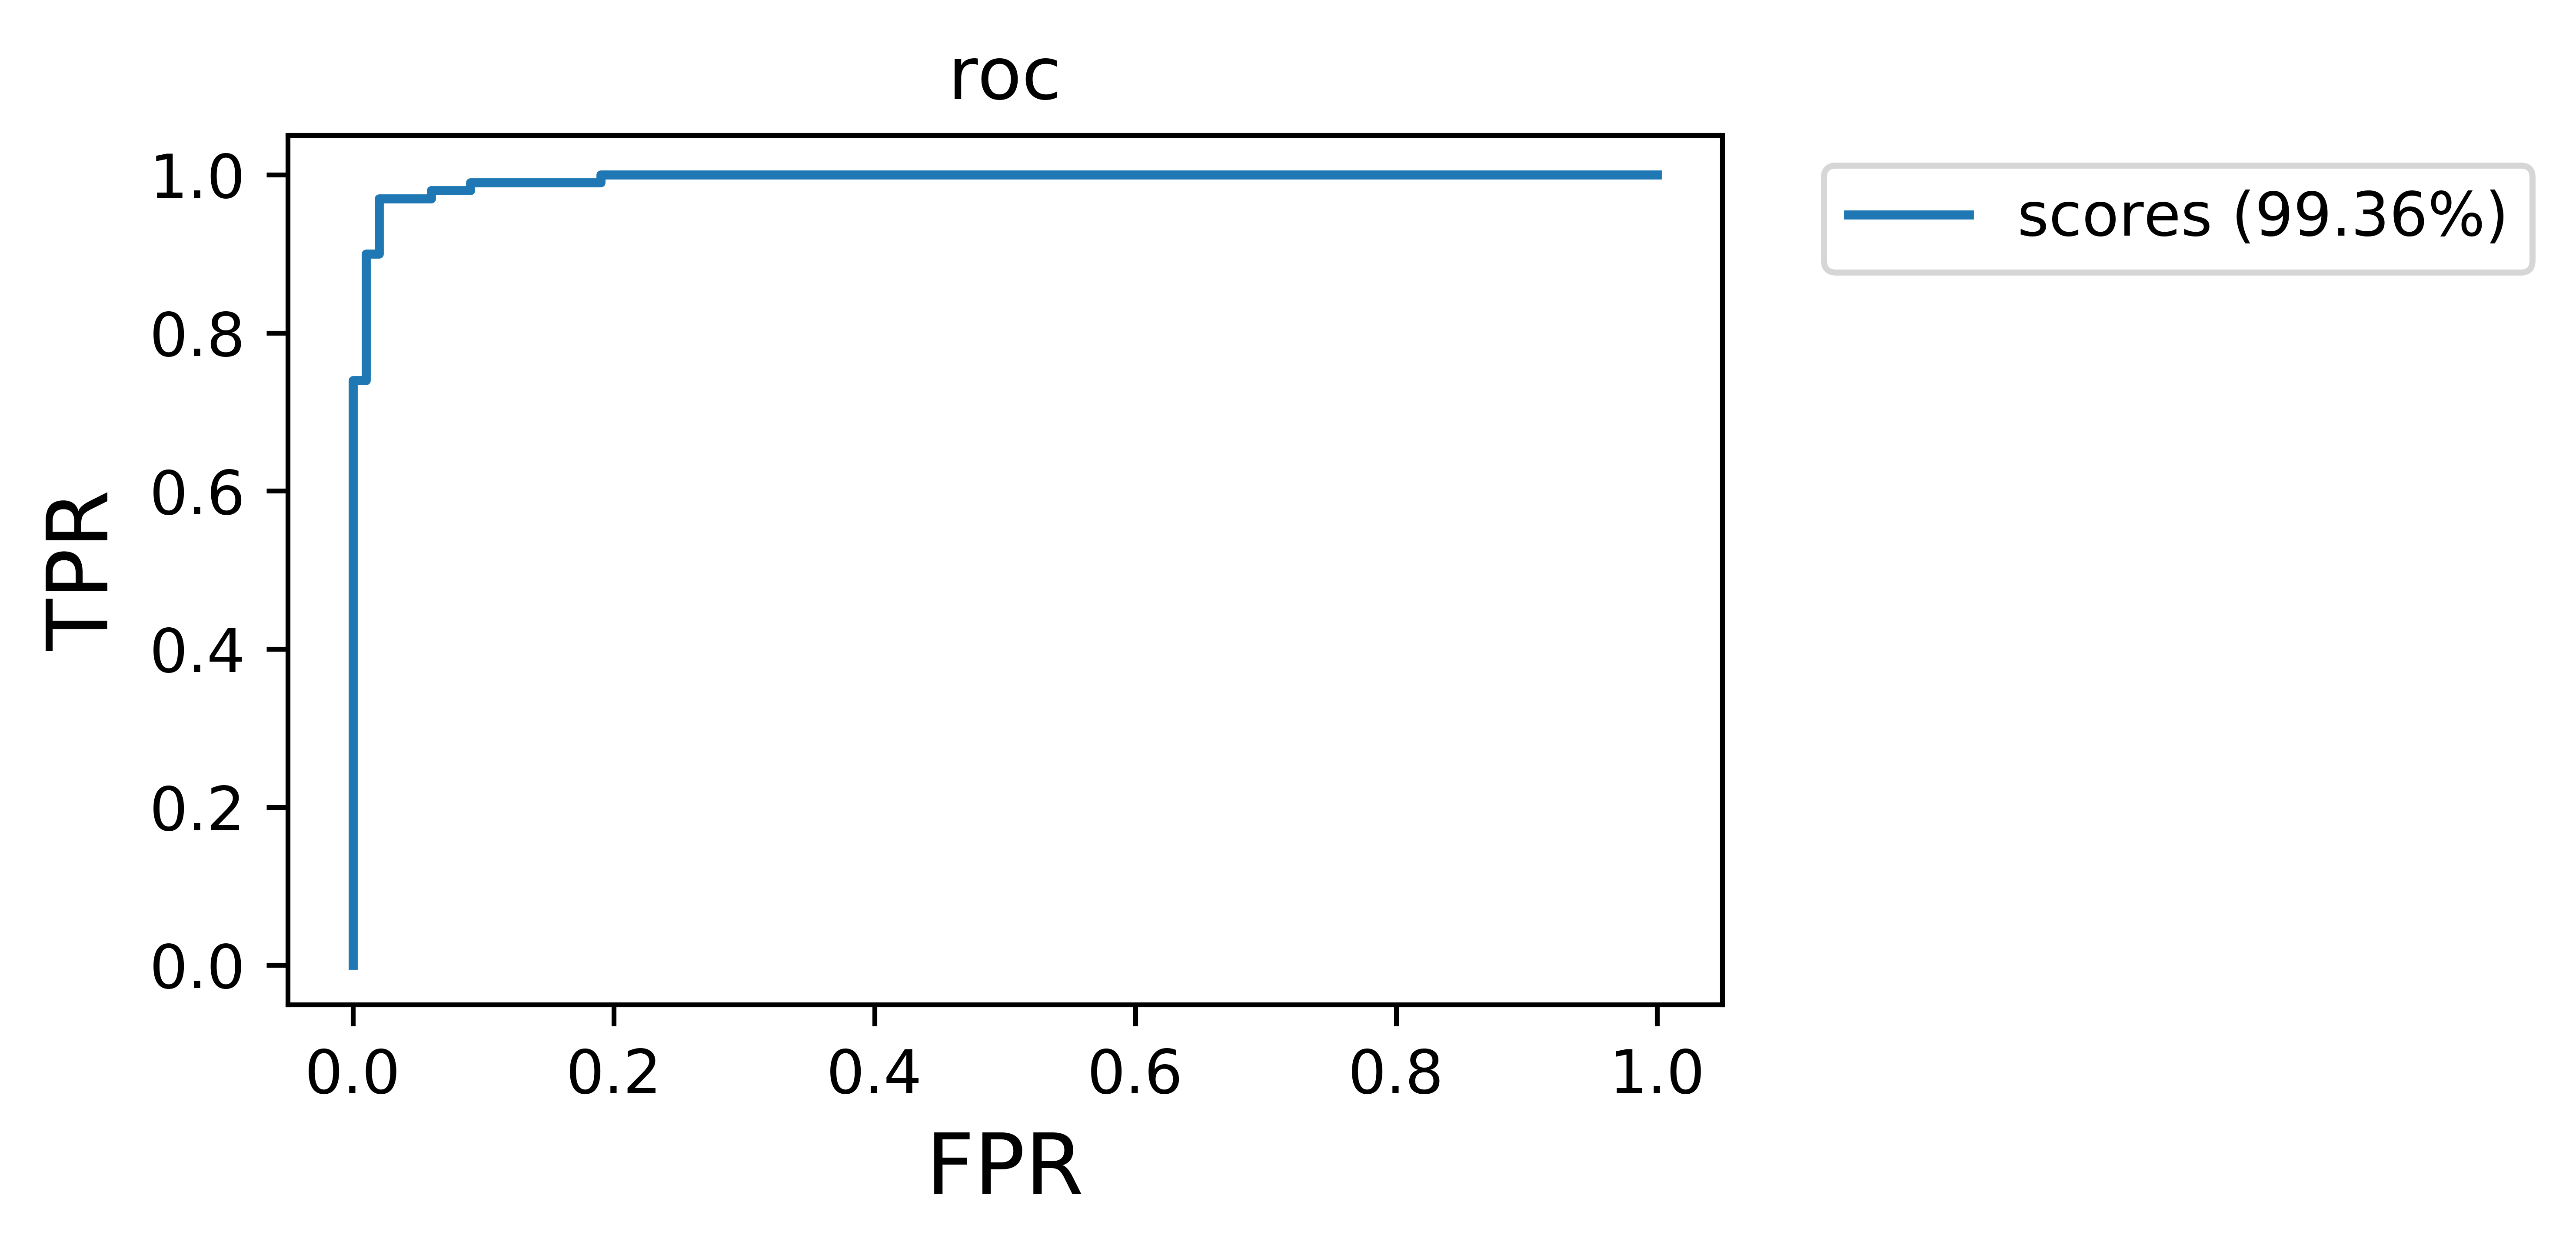

In [17]:
Image(os.path.join(evaluation_folder, 'roc.png'))

It is also possible to inspect the hidden layers for example by clustering the hidden feature activities.

array([[1.6746709 , 0.45587528, 0.5688033 , ..., 1.9066777 , 0.2681408 ,
        0.45561033],
       [1.37975   , 0.53738064, 0.58297694, ..., 1.7481748 , 0.43854377,
        0.46126264],
       [1.6419414 , 0.50214165, 0.6701963 , ..., 1.7774826 , 0.32664016,
        0.5453135 ],
       ...,
       [1.6479969 , 0.7628179 , 0.68694425, ..., 1.7140568 , 0.6026458 ,
        0.8016584 ],
       [1.7427936 , 0.8301672 , 0.7201004 , ..., 1.9760699 , 0.6058396 ,
        0.82219326],
       [1.5701522 , 0.40979022, 0.57646537, ..., 1.4924986 , 0.39787322,
        0.56569016]], dtype=float32)

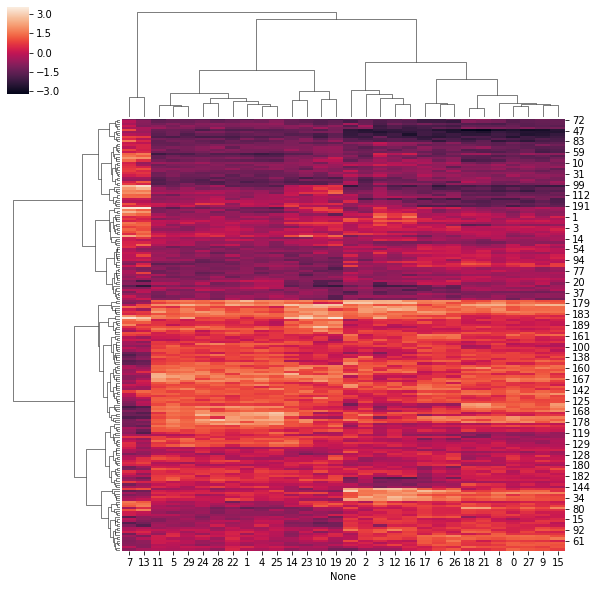

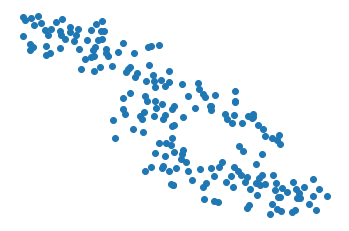

In [18]:
# clustering plots based on hidden features
heatmap_eval = Scorer('heatmap', exporter=ExportClustermap(z_score=1.))
tsne_eval = Scorer('tsne', exporter=ExportTsne())

model.predict(DNA_TEST, datatags=['test'],
              callbacks=[heatmap_eval, tsne_eval],
              layername='motif')

## 3) Reusing the same dataset for training and test regions

When you have loaded the datasets using the store_whole_genome=True option, it is possible to reuse the same
dataset with different region of interests. To this end, the view method can be used to create another view on the dataset.
The advantage of this option is that the memory footprint will remain the same.

In [19]:
from janggu.data import view

In [20]:
DNA_TRAIN = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   order=order,
                                   binsize=200,
                                   store_whole_genome=True)
                                   
LABELS_TRAIN = Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200,
                               storage='sparse',
                               store_whole_genome=True)


DNA_TEST = view(DNA_TRAIN, ROI_TEST_FILE)
LABELS_TEST = view(DNA_TRAIN, ROI_TEST_FILE)

loading from lazy loader
loading from bed lazy loader


In [21]:
DNA_TRAIN.shape, DNA_TEST.shape

((7797, 198, 1, 64), (200, 198, 1, 64))

In [22]:
LABELS_TRAIN.shape, LABELS_TEST.shape

((7797, 1, 1, 1), (200, 198, 1, 64))

To some extent view can also be used if the option store_whole_genome=False was selected. However, in this case please make sure that the
dataset was originally loaded with the union of all regions that are relevant e.g. training and test sets.

This is shown in the following example.

In [23]:

# ROI contains regions spanning positive and negative examples
ROI_FILE = resource_filename('janggu', 'resources/roi.bed')
ROI_TRAIN_FILE = resource_filename('janggu', 'resources/roi_train.bed')
ROI_TEST_FILE = resource_filename('janggu', 'resources/roi_test.bed')

# First load the union of all peaks
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_FILE,
                                   order=order,
                                   binsize=200,
                                   store_whole_genome=False)
                                   
LABELS = Cover.create_from_bed('peaks', roi=ROI_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200,
                               storage='sparse',
                               store_whole_genome=False)

# in case the dataset has been loaded with store_whole_genome=True,
# it is possible to reuse the same dataset by subsetting on different
# regions of the genome.                
DNA_TRAIN = view(DNA, ROI_TRAIN_FILE)
LABELS_TRAIN = view(LABELS, ROI_TRAIN_FILE)
DNA_TEST = view(DNA, ROI_TEST_FILE)
LABELS_TEST = view(LABELS, ROI_TEST_FILE)



loading from lazy loader
loading from bed lazy loader


In [24]:
DNA_TRAIN.shape, DNA_TEST.shape

((7797, 198, 1, 64), (200, 198, 1, 64))

In [25]:
LABELS_TRAIN.shape, LABELS_TEST.shape

((7797, 1, 1, 1), (200, 1, 1, 1))

## 4) Working with HDF5 datasets 

Using data directly from HDF5 can be tricky.
For example, it might be prohibitively slow to use data 
from HDF5 with in conjunction with randomization option in the model.fit method.
HDF5 data may be read more efficiently in coherent blocks.

To overcome this limitation, it is possible to randomize the dataset already at loading time.
That way randomization may be avoided in the model.fit method such that coherent yet randomized batches are consumed
during training.

For the randomization to be effective, use store_whole_genome=False and use the same random_state for all training dataset objects to make sure that the intervals are aligned.

In [26]:
# Training input and labels are purely defined genomic coordinates
# applying a random state internally randomizes the dataset
# in this case, shuffling of the mini-batches during training
# becomes obsolete.
# Importantly, the same state needs to be used for all datasets
# to enforce synchronized datasets.
DNA = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                   roi=ROI_TRAIN_FILE,
                                   binsize=200,
                                   order=order,
                                   storage='hdf5',
                                   cache=True,
                                   store_whole_genome=False,
                                   random_state=43)

LABELS = Cover.create_from_bed('peaks', roi=ROI_TRAIN_FILE,
                               bedfiles=PEAK_FILE,
                               binsize=200,
                               resolution=200,
                               storage='sparse',
                               cache=True,
                               store_whole_genome=True,
                               random_state=43)

loading from lazy loader
reload /home/wkopp/janggu_examples/datasets/dna/694c640f5138bac7807a91e6335981fae1e9c547d0e163db6863abc6fb4804f1.h5
reload /home/wkopp/janggu_examples/datasets/peaks/8a2c90d6b9457677115b76fd90f44cd1a8c7f1aa0f6fbb6b3d939a2b74eca4b8.npz


Now you may use shuffle=False for the model fit method.

In [28]:
# create a new model object
model = Janggu.create(template=double_stranded_model_dnaconv,
                      modelparams=(30, 21, 'relu'),
                      inputs=DNA,
                      outputs=ReduceDim(LABELS))

model.compile(optimizer='adadelta', loss='binary_crossentropy',
              metrics=['acc'])

hist = model.fit(DNA, ReduceDim(LABELS), epochs=100, shuffle=False)

print('#' * 40)
print('loss: {}, acc: {}'.format(hist.history['loss'][-1],
                                 hist.history['acc'][-1]))
print('#' * 40)




Generated model-id: '2c139ef309bf77927c528877cc683b85'
Epoch 1/100
244/244 [==============================] - 12s 50ms/step - loss: 0.5714 - acc: 0.7379
Epoch 2/100
244/244 [==============================] - 12s 48ms/step - loss: 0.4681 - acc: 0.7975
Epoch 3/100
244/244 [==============================] - 12s 49ms/step - loss: 0.4206 - acc: 0.8189
Epoch 4/100
244/244 [==============================] - 12s 48ms/step - loss: 0.3886 - acc: 0.8347
Epoch 5/100
244/244 [==============================] - 12s 47ms/step - loss: 0.3620 - acc: 0.8498
Epoch 6/100
244/244 [==============================] - 12s 49ms/step - loss: 0.3377 - acc: 0.8631
Epoch 7/100
244/244 [==============================] - 12s 50ms/step - loss: 0.3146 - acc: 0.8758
Epoch 8/100
244/244 [==============================] - 12s 50ms/step - loss: 0.2925 - acc: 0.8879
Epoch 9/100
244/244 [==============================] - 12s 50ms/step - loss: 0.2716 - acc: 0.8973
Epoch 10/100
244/244 [==============================] - 12s 50m

244/244 [==============================] - 12s 48ms/step - loss: 0.0183 - acc: 0.9987
Epoch 84/100
244/244 [==============================] - 12s 50ms/step - loss: 0.0178 - acc: 0.9987
Epoch 85/100
244/244 [==============================] - 11s 44ms/step - loss: 0.0174 - acc: 0.9988
Epoch 86/100
244/244 [==============================] - 11s 44ms/step - loss: 0.0170 - acc: 0.9990
Epoch 87/100
244/244 [==============================] - 11s 45ms/step - loss: 0.0165 - acc: 0.9992
Epoch 88/100
244/244 [==============================] - 11s 45ms/step - loss: 0.0161 - acc: 0.9992
Epoch 89/100
244/244 [==============================] - 11s 47ms/step - loss: 0.0157 - acc: 0.9994
Epoch 90/100
244/244 [==============================] - 11s 43ms/step - loss: 0.0153 - acc: 0.9995
Epoch 91/100
244/244 [==============================] - 10s 42ms/step - loss: 0.0150 - acc: 0.9995
Epoch 92/100
244/244 [==============================] - 10s 41ms/step - loss: 0.0146 - acc: 0.9995
Epoch 93/100
244/244 [=

For the test sets and evaluation, you may use the datasets without randomization as usual.

In [29]:
DNA_TEST = Bioseq.create_from_refgenome('dna', refgenome=REFGENOME,
                                        roi=ROI_TEST_FILE,
                                        binsize=200,
                                        storage='hdf5',
                                        cache=True,
                                        order=order)

LABELS_TEST = Cover.create_from_bed('peaks',
                                    bedfiles=PEAK_FILE,
                                    roi=ROI_TEST_FILE,
                                    binsize=200,
                                    storage='hdf5',
                                    cache=True,
                                    resolution=200)


loading from lazy loader
reload /home/wkopp/janggu_examples/datasets/dna/3c0a92675de13fdb3840292a766f7991cd52049abf727c4834a9e8822e866d9e.h5
loading from bed lazy loader
reload /home/wkopp/janggu_examples/datasets/peaks/5499ece27c1c9a6335da1a50bbd6072f034f600af491636f5d311b6fe53a0a52.h5


In [ ]:
# do the evaluation on the independent test data
model.evaluate(DNA_TEST, ReduceDim(LABELS_TEST), datatags=['test'],
               callbacks=['auc', 'auprc', 'roc', 'prc'])